## LANL-Earthquake-Prediction  with GRU
Referenced some ideas for feature engineering and dataset overview from [Kaggle kernels](https://www.kaggle.com/c/LANL-Earthquake-Prediction/kernels)

In [12]:
#kaggleコンペのデータをダウンロードするための準備
!pip install kaggle
!pip install numpy==1.16.0 #numpy.quantileを使いたいため

    100% |████████████████████████████████| 17.3MB 2.2MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
tensorflow 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 1.12.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [2]:
#import data files from kaggle
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2468           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10007            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4056           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2452           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [4]:
#download the Earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 12.9MB/s]
 96% 233M/242M [00:05<00:00, 39.5MB/s]
100% 242M/242M [00:05<00:00, 50.0MB/s]
100% 2.02G/2.03G [00:46<00:00, 49.2MB/s]
100% 2.03G/2.03G [00:46<00:00, 46.4MB/s]


In [5]:
#Dowloadした訓練用ファイルを展開
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [1]:
#Explore the data
import numpy as np
import pandas as pd

#acoustic_data: 地震波信号のデータ
#time_to_failure: 次の地震(laboratory earthquake)発生までの時間

train = pd.read_csv("train.csv", nrows=60000000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})
print(train.shape)
train.head()

(60000000, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [0]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train["acoustic_data"].values[::100]
train_ttf_sample_df = train["time_to_failure"].values[::100]

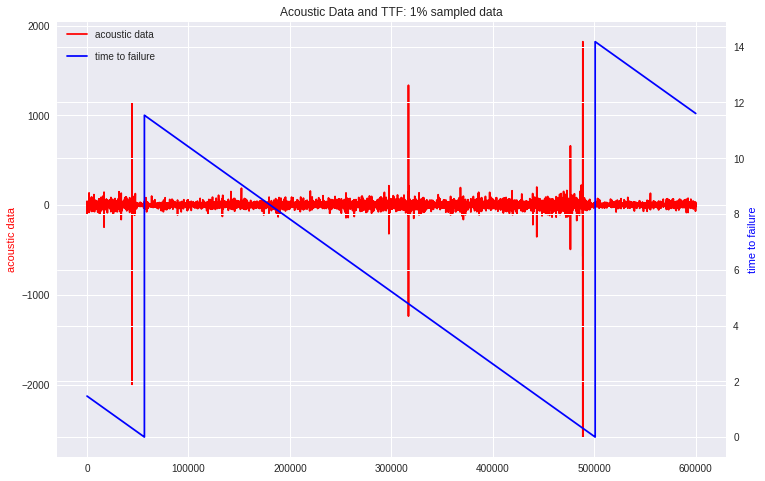

In [9]:
import matplotlib.pyplot as plt

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic Data and TTF: 1% sampled data"):
  fig, ax1 = plt.subplots(figsize=(12, 8))
  plt.title(title)
  plt.plot(train_ad_sample_df, color='r')
  ax1.set_ylabel('acoustic data', color='r')
  plt.legend(['acoustic data'], loc = (0.01, 0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df, color='b')
  ax2.set_ylabel('time to failure', color='b')
  plt.legend(['time to failure'], loc=(0.01, 0.9))
  plt.grid(True)
  
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:
#Add some statistical features to the dataset
#特徴量サンプリングとして基本的な統計量をいくつか追加してみる
#平均、標準偏差、最小値、最大値、尖度(kurtosis)、歪度(skewness)
def gen_features(X):
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.max())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X, 0.05))
  strain.append(np.quantile(X, 0.95))
  return pd.Series(strain)



In [4]:
train = pd.read_csv("train.csv", iterator=True, chunksize=30000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()

for chunk in train:
  df = df.append(chunk)
  if len(df) >= 150000:
    df = df[-150000:]
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    
X_train.describe()

,0,1,2,3,4,5,6,7
count,20968.000000,20968.000000,20968.000000,20968.000000,20968.000000,20968.000000,20968.000000,20968.000000
mean,4.519425,6.550723,-149.491559,163.685664,68.391680,0.125519,-2.190035,11.233081
std,0.256083,8.502778,266.377048,274.170390,70.958953,0.484344,2.374845,2.379806
min,3.557867,2.794581,-5515.000000,23.000000,0.432128,-5.515521,-45.000000,9.000000
25%,4.352148,4.469465,-155.000000,91.000000,28.054235,-0.038781,-3.000000,10.000000
50%,4.522970,5.597123,-111.000000,123.000000,45.633900,0.086165,-2.000000,11.000000
75%,4.692917,6.884724,-79.000000,170.000000,79.500788,0.256146,-1.000000,12.000000
max,5.463813,153.706621,-15.000000,5444.000000,826.950662,4.944953,1.000000,56.000000


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
print(X_train.shape)
X_train[0]

(20968, 8)


array([ 1.42413805, -0.17049155,  0.1933079 , -0.2177007 , -0.48943827,
       -0.30883894,  0.0800218 , -0.09794368])

In [9]:
#Reshape for GRU input
n_features = X_train.shape[1]
X_train = np.reshape(np.array(X_train), (X_train.shape[0], 1, X_train.shape[1]))

(20968, 1, 8)

In [12]:
#RNN model
from keras.models import Sequential
from keras.layers import Dense,　GRU
from keras.callbacks import ModelCheckpoint


cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(GRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 48)                8208      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 8,709
Trainable params: 8,709
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.optimizers import adam
model.compile(optimizer=adam(lr=0.0005), loss="MAE")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_split = 0.1)

Instructions for updating:
Use tf.cast instead.
Train on 18871 samples, validate on 2097 samples
Epoch 1/20
18871/18871 [==============================] - 6s 338us/step - loss: 3.4483 - val_loss: 1.6629
Epoch 2/20
18871/18871 [==============================] - 3s 182us/step - loss: 2.2041 - val_loss: 1.6832
Epoch 3/20
18871/18871 [==============================] - 3s 185us/step - loss: 2.1730 - val_loss: 1.8930
Epoch 4/20
18871/18871 [==============================] - 3s 179us/step - loss: 2.1589 - val_loss: 1.9135
Epoch 5/20
18871/18871 [==============================] - 3s 183us/step - loss: 2.1521 - val_loss: 1.8603
Epoch 6/20
18871/18871 [==============================] - 3s 184us/step - loss: 2.1488 - val_loss: 1.8907
Epoch 7/20
18871/18871 [==============================] - 3s 182us/step - loss: 2.1463 - val_loss: 1.9260
Epoch 8/20
18871/18871 [==============================] - 3s 184us/step - loss: 2.1442 - val_loss: 1.9445
Epoch 9/20
18871/18871 [==============================]

In [14]:
#テストデータを展開
!unzip test.zip
!ls

Archive:  test.zip
  inflating: seg_430e66.csv          
  inflating: seg_d1a281.csv          
  inflating: seg_05a1b0.csv          
  inflating: seg_f8dd7e.csv          
  inflating: seg_b9bdd7.csv          
  inflating: seg_24c1c9.csv          
  inflating: seg_c5abaa.csv          
  inflating: seg_6262c4.csv          
  inflating: seg_734a88.csv          
  inflating: seg_94a133.csv          
  inflating: seg_d0c280.csv          
  inflating: seg_d36737.csv          
  inflating: seg_f80e44.csv          
  inflating: seg_07c815.csv          
  inflating: seg_7c9433.csv          
  inflating: seg_211486.csv          
  inflating: seg_78ded2.csv          
  inflating: seg_f11f77.csv          
  inflating: seg_b3883e.csv          
  inflating: seg_3db0a8.csv          
  inflating: seg_81f798.csv          
  inflating: seg_0a45a1.csv          
  inflating: seg_dc188b.csv          
  inflating: seg_4a9e8d.csv          
  inflating: seg_32fc4e.csv          
  inflating: seg_7b2994.csv    

In [15]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

for seg_id in submission.index:
    seg = pd.read_csv(seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test = sc.fit_transform(X_test)
print(X_test.shape)

(2624, 8)


In [0]:
X_test = np.reshape(np.array(X_test), (X_test.shape[0], 1, X_test.shape[1]))
preds = model.predict(X_test)

In [0]:
submission['time_to_failure'] = preds
submission.to_csv('submission.csv')

In [18]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "Message"

100% 52.6k/52.6k [00:09<00:00, 5.50kB/s]
Successfully submitted to LANL Earthquake Prediction

↑結果はscore: 1.703でした

### For further improvements
*   Add some layers to the network
*   Add(or get rid of) some features
*   Try XGBoosting or CatBoost and see the difference